## imports & installations

In [ ]:
import pickle
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
import sys
import itertools
import os
from scipy.stats import normaltest
from itertools import groupby
import datetime

warnings.simplefilter('ignore', pd.errors.DtypeWarning)
np.seterr(divide='ignore')
warnings.simplefilter("ignore")

sys.path.append('/sise/home/shakarch/muscle-formation-regeneration')
sys.path.append(os.path.abspath('..'))

import TimeSeriesAnalysis.analysis.calc_single_cell_properties as calcultator 
import TimeSeriesAnalysis.analysis.calc_auc_over_time as auc_calculator 
import TimeSeriesAnalysis.analysis.utils as utils
import TimeSeriesAnalysis.data_layer.utils as data_utils
import TimeSeriesAnalysis.configuration.consts as consts

## data loading - differentiation scores dataframes

In [ ]:
scores_df_s3 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S3.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S3.pkl")

scores_df_s2 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (1,5) + fr"df_score_vid_num_S2.pkl",
                              scores_intensity_path=consts.intensity_model_path % (1,5) + fr"df_score_vid_num_S2.pkl")

scores_df_s5 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S5.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S5.pkl")

scores_df_s1 = utils.get_scores_df(scores_motility_path=consts.motility_model_path % (2,3) + fr"df_score_vid_num_S1.pkl",
                              scores_intensity_path=consts.intensity_model_path % (2,3) + fr"df_score_vid_num_S1.pkl")

Calculate single cell properties

In [ ]:
scores_df_s3 = calcultator.get_properties(scores_df_s3, vid_name="S3", actin_vid_path=consts.s_runs["3"]['actin_path'])
scores_df_s2 = calcultator.get_properties(scores_df_s2, vid_name="S2", actin_vid_path=consts.s_runs["2"]['actin_path'])
scores_df_s5 = calcultator.get_properties(scores_df_s5, vid_name="S5", actin_vid_path=consts.s_runs["5"]['actin_path'])
scores_df_s1 = calcultator.get_properties(scores_df_s1, vid_name="S1", actin_vid_path=consts.s_runs["1"]['actin_path'])

# Models' performance

display models performance- actin intensity/motility seperately. 

We will display the following metrics:
1. accuracy
2. specificity
3. sensitivity 
4. precision
5. AUC

We will display the following graphs:
1. ROC curve
2. AUC over time

We will now combine the actin and motility time series, train a new model and assess its performance.

In [31]:
def build_combined_model(con_test_n, diff_test_n, con_train_n, diff_train_n, saving_path):
    # load motility data
    data_path = consts.motility_model_path % (con_train_n, diff_train_n)
    _, x_train_mot, x_test_mot, y_train_mot, y_test_mot = data_utils.load_data(data_path, load_clf=True, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
    
    # load actin_intensity data
    data_path = consts.intensity_model_path % (con_train_n, diff_train_n)
    _, x_train_int, x_test_int, y_train_int, y_test_int = data_utils.load_data(data_path, load_clf=False, load_x_train=True, load_x_test=True, load_y_train=True, load_y_test=True)
    
    # combine features
    x_train = x_train_mot.merge(x_train_int, on="Spot track ID", how="right")
    x_test = x_test_mot.merge(x_test_int, on="Spot track ID", how="right")
    y_train = y_train_mot.merge(y_train_int, on=["Spot track ID", "target"], how="right")
    y_test = y_test_mot.merge(y_test_int, on=["Spot track ID", "target"], how="right")
    
    combined_clf = utils.train_model(x_train.drop(columns=['Spot track ID']), y_train["target"], modality=None)
    # save data & model 
    os.makedirs(saving_path, exist_ok=True)
    data_utils.save_data(saving_path, clf=combined_clf, X_train=x_train, X_test=x_test, y_train=y_train, y_test=y_test)
    del x_train
    del y_train
    
    utils.evaluate_model(combined_clf, x_test, y_test, modality="combined", con_test_n=con_test_n, diff_test_n=diff_test_n)
    
    return combined_clf

Evaluation metrics for combined based model, trained on videos (s2, s3):
accuracy: 0.831
specificity: 0.928
sensitivity (recall): 0.801
precision: 0.973
AUC: 0.864


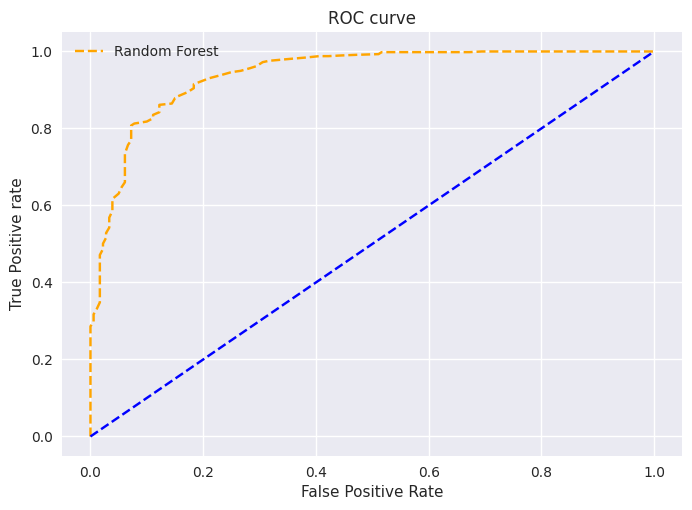

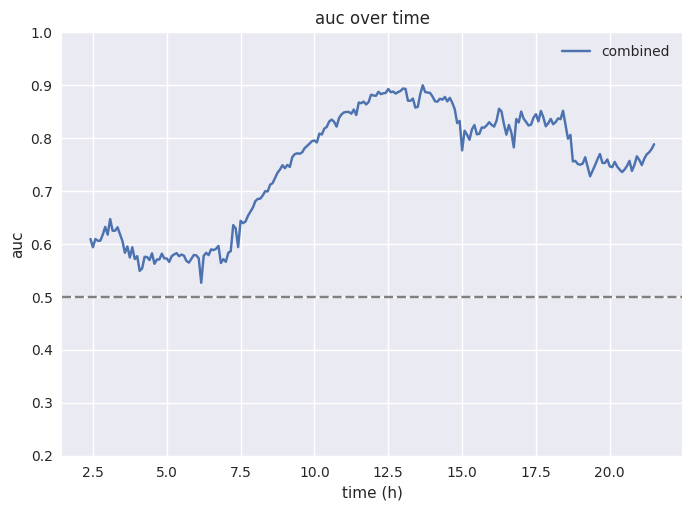

Evaluation metrics for combined based model, trained on videos (s1, s5):
accuracy: 0.774
specificity: 0.682
sensitivity (recall): 0.933
precision: 0.631
AUC: 0.807


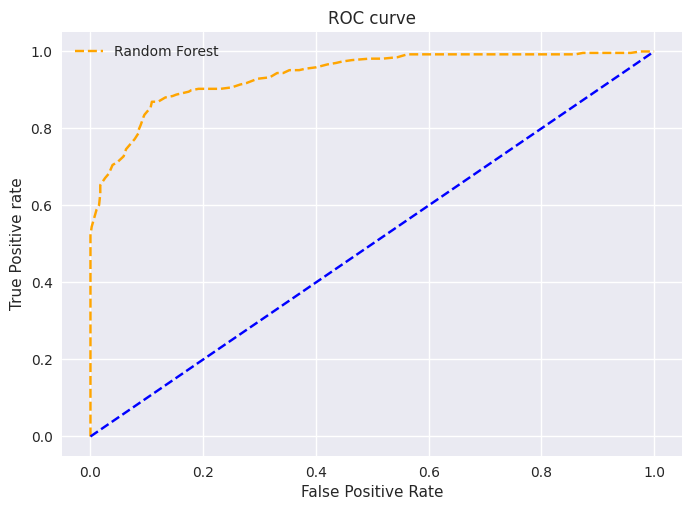

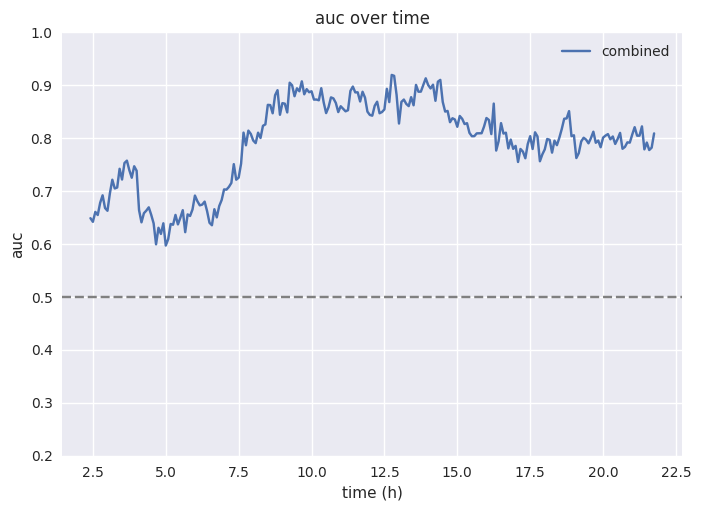

<Figure size 800x550 with 0 Axes>

In [14]:
train_vid_nums = [(1,5), (2,3)]
test_vid_nums = [(2,3), (1,5)]

for (con_train_n, diff_train_n), (con_test_n, diff_test_n) in zip(train_vid_nums, test_vid_nums):
    saving_path = f"{consts.storage_path}{datetime.datetime.now().strftime('%d-%m-%Y')}- combined motility & actin features, s{con_train_n}, s{diff_train_n} train"
    combined_clf = build_combined_model(con_test_n, diff_test_n, con_train_n, diff_train_n, saving_path)
    cols = list(combined_clf.feature_names_in_) + ["Spot track ID", "Spot frame"]

    # calculate single cells differentiation trajectories   
    for test_n in (con_test_n, diff_test_n):
        tsfresh_df = data_utils.load_tsfresh_transformed_df("combined", test_n)
        tsfresh_df = tsfresh_df[cols]
        if not os.path.exists(saving_path + f"/df_score_vid_num_S{test_n}.pkl"):
            print("calculating diff scores single cell trajectories")
            df_score = utils.calc_prob(tsfresh_df.dropna(axis=1), combined_clf, n_frames=260)
            pickle.dump(df_score, open(saving_path + f"/df_score_vid_num_S{test_n}.pkl", 'wb'))

<AxesSubplot: xlabel='model_type'>

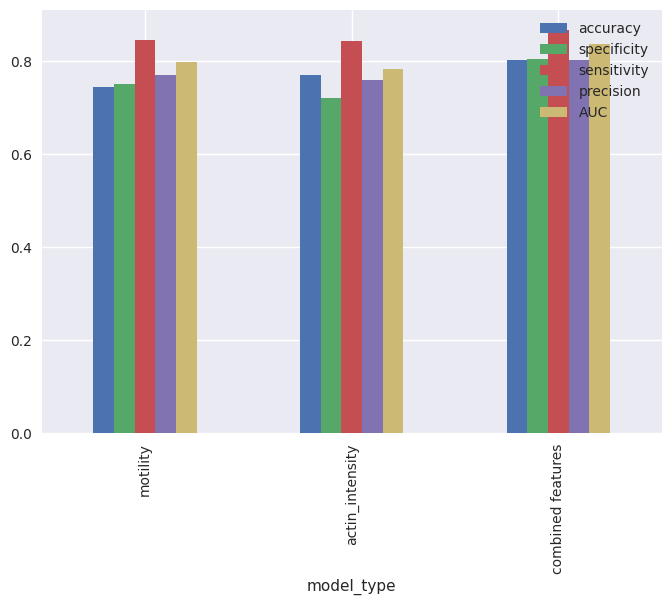

In [81]:
data = pd.DataFrame()
data = data.append({"accuracy": np.mean([0.76, 0.727]), "specificity": np.mean([0.917, 0.583]), "sensitivity": np.mean([0.711, 0.978]), "precision": np.mean([0.965, 0.573]), "AUC": np.mean([0.814, 0.78]), "model_type": "motility"}, ignore_index=True)
data = data.append({"accuracy": np.mean([0.808, 0.73]), "specificity": np.mean([0.794, 0.647]), "sensitivity": np.mean([0.813, 0.873]), "precision": np.mean([0.927, 0.591]), "AUC": np.mean([0.804, 0.76]), "model_type": "actin_intensity"}, ignore_index=True)
data = data.append({"accuracy": np.mean([0.831, 0.774]), "specificity": np.mean([0.928, 0.682]), "sensitivity": np.mean([0.801, 0.933]), "precision": np.mean([0.973, 0.631]), "AUC": np.mean([0.864, 0.807]), "model_type": "combined features"}, ignore_index=True)

data.plot(x="model_type", y=["accuracy", "specificity", "sensitivity", "precision", "AUC"], kind="bar")

Let's see the differentiation score over time for the motility & actin intensity combined model

In [7]:
# load single cells differentiation trajectories dataframes
combined_scores_path = f"{consts.storage_path}13-05-2023- combined motility & actin features, s%s, s%s train/"

scores_df_combined_s2 = utils.convert_score_df(pickle.load(open(combined_scores_path % (1,5) +"df_score_vid_num_S2.pkl", 'rb'))  , "combined")
scores_df_combined_s3 = utils.convert_score_df(pickle.load(open(combined_scores_path % (1,5) +"df_score_vid_num_S3.pkl", 'rb'))  , "combined")

scores_df_combined_s1 = utils.convert_score_df(pickle.load(open(combined_scores_path % (2,3) +"df_score_vid_num_S1.pkl", 'rb'))  , "combined")
scores_df_combined_s5 = utils.convert_score_df(pickle.load(open(combined_scores_path % (2,3) +"df_score_vid_num_S5.pkl", 'rb'))  , "combined")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


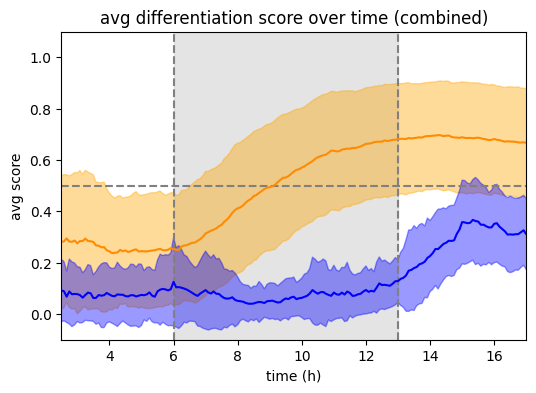

<Figure size 640x480 with 0 Axes>

In [8]:
data_2_3_test  = [(scores_df_combined_s3, "ERKi", "DarkOrange","Orange"), (scores_df_combined_s2, "DMSO", "blue", "blue"),]
utils.plot_avg_conf(data_2_3_test, "combined", path=fig_dir_path + "avg diff over time train (1,5) test (2,3) combined", plot_std=True, frames=(72,156), xlim=(2.5, 17))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


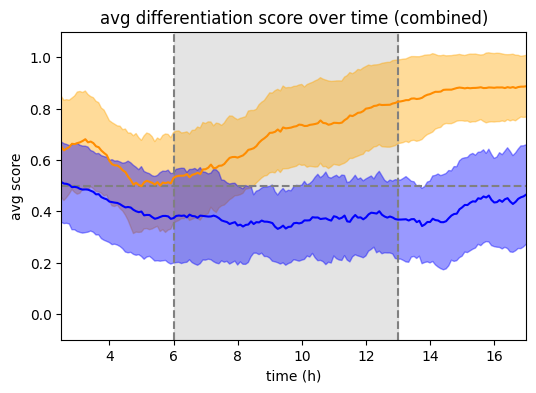

<Figure size 640x480 with 0 Axes>

In [9]:
data_1_5_test  = [(scores_df_combined_s5, "ERKi", "DarkOrange","Orange"), (scores_df_combined_s1, "DMSO", "blue", "blue"),]
utils.plot_avg_conf(data_1_5_test, "combined", path=fig_dir_path + "avg diff over time train (1,5) test (2,3) combined", plot_std=True, frames=(72,156), xlim=(2.5, 17))